In [279]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import scipy.optimize as optm

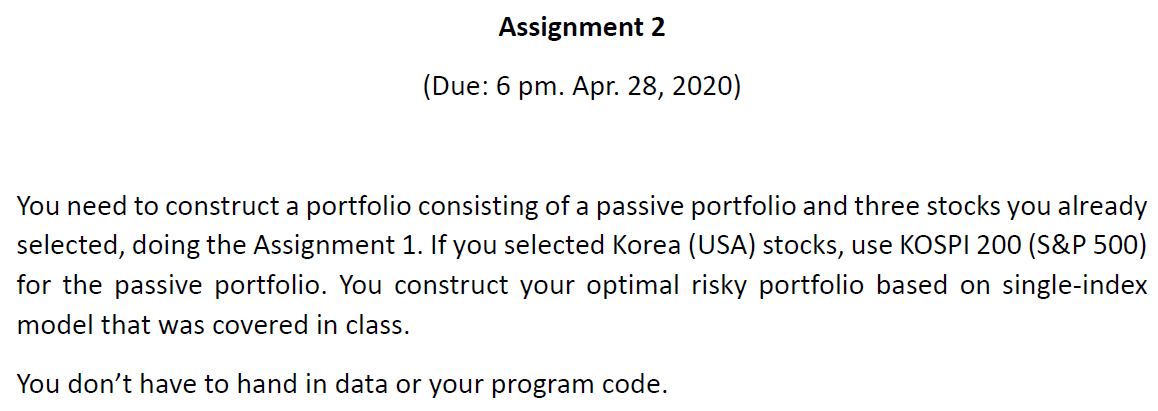

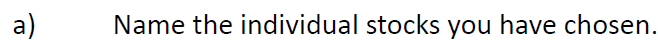

In [125]:
Celltrion = fdr.DataReader('068270', '2015-3', '2020-4')['Close']
Samsung = fdr.DataReader('005930', '2015-3', '2020-4')['Close']
NCsoft = fdr.DataReader('036570', '2015-3', '2020-4')['Close']
KOSPI = fdr.DataReader('KS11', '2015-3', '2020-4')['Close']

Stocks = pd.concat([Celltrion, Samsung, NCsoft, KOSPI], axis=1)
Stocks = Stocks.iloc[:-1,:]
Stocks.columns = ['Celltrion', 'Samsung', 'NCsoft', 'KOSPI']

In [127]:
# a 정답
Stocks.columns.tolist()[:3]

['Celltrion', 'Samsung', 'NCsoft']

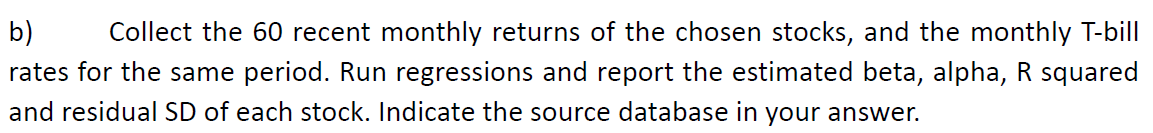

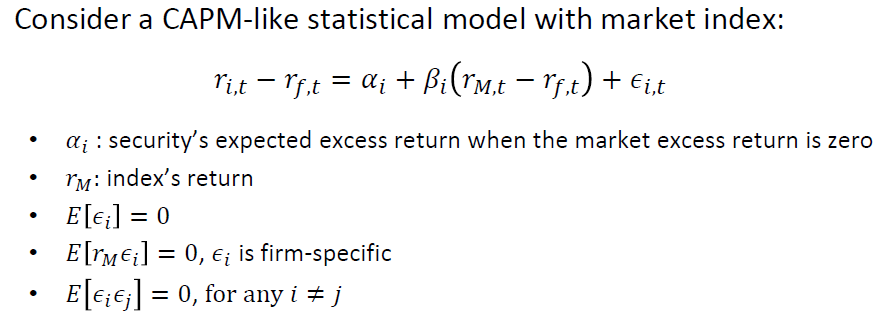

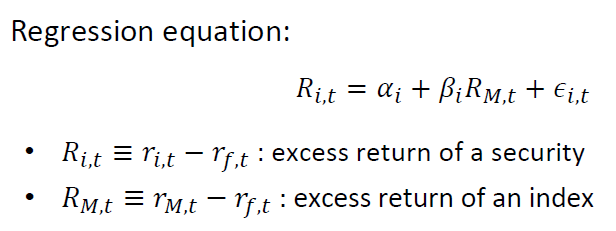

In [134]:
m_mean = Stocks.resample('BM').last().pct_change().dropna()

risk_free = pd.DataFrame( pd.read_csv('./bok_standard_rate.csv')['rate'] )
risk_free.index = m_mean.index
risk_free.columns = ['risk_free_rate']
risk_free = risk_free.applymap(lambda x : x / 100 / 12)

row_data = pd.concat([m_mean, risk_free], axis=1)

In [139]:
excess_market = row_data['KOSPI']- row_data['risk_free_rate']

excess_stock1 = row_data['Celltrion'] - row_data['risk_free_rate']
excess_stock2 = row_data['Samsung'] - row_data['risk_free_rate']
excess_stock3 = row_data['NCsoft'] - row_data['risk_free_rate']

excess_data = pd.concat([excess_stock1, excess_stock2, excess_stock3, excess_market], axis = 1)
excess_data.columns = ['Celltrion', 'Samsung', 'NCsoft', 'KOSPI']

stock_list = row_data.columns[:3].tolist()

In [200]:
stat = pd.DataFrame(index = ['alpha', 'beta', 'R_sqaured', 'residual_SD'], columns = stock_list)
tmp_list = []

for stock in stock_list :
    result_reg = ols( stock + '~ KOSPI', data = excess_data ).fit()
    stat[stock] = [ result_reg.params[0], result_reg.params[1], result_reg.rsquared, np.std(result_reg.resid) ]

In [202]:
stat_T = stat.T

In [236]:
stat_T

,alpha,beta,R_sqaured,residual_SD
Celltrion,0.031626,0.846971,0.059096,0.131900
Samsung,0.013430,1.285300,0.505703,0.049595
NCsoft,0.025175,0.331749,0.021107,0.088175


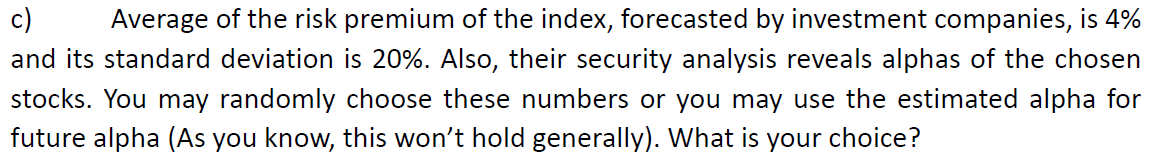

In [306]:
ave_risk_premium = 0.04 / 12
ave_sd = 0.2 / 12
tmp_alpha = [0.01, 0.02, 0.03]

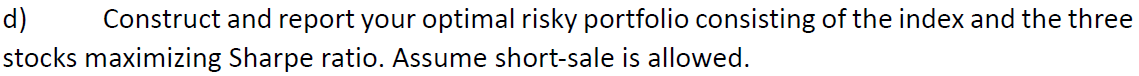

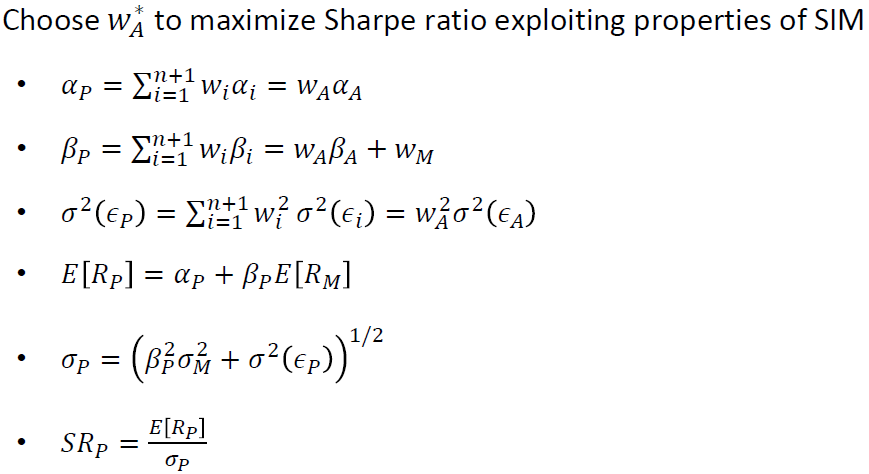

### 임의의 alpha의 경우

In [380]:
# 초기 weight값, 마지막은 index_weight
tmp_w = [0.25, 0.25, 0.25, 0.25]
cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]

In [381]:
alpha = sum(np.array(tmp_alpha) * np.array(tmp_w[:3]))
beta = sum( ( stat_T['beta'] *  tmp_w[:3] ) +  tmp_w[3] )
port_excess_ret = alpha + beta * ave_risk_premium
residual_var = sum ( ( stat_T['residual_SD'] * np.array(tmp_w[:3]) ) ** 2 )
port_sd = ( (beta * ave_sd) ** 2 + residual_var ) ** 0.5
port_sr = port_excess_ret / port_sd

In [382]:
def objective(x) :
    alpha = sum(np.array(tmp_alpha) * np.array(x[:3]))
    beta = sum( ( stat_T['beta'] *  x[:3] ) +  x[3] )
    port_excess_ret = alpha + beta * ave_risk_premium
    residual_var = sum ( ( stat_T['residual_SD'] * np.array(x[:3]) ) ** 2 )
    port_sd = ( (beta * ave_sd) ** 2 + residual_var ) ** 0.5
    port_sr = port_excess_ret / port_sd
    return - port_sr

In [383]:
tangent_portfolio = optm.minimize(objective, tmp_w, method = 'SLSQP', constraints = cons)

In [384]:
optimized_SR = - tangent_portfolio.fun
print('optimized_SR : ' + str(optimized_SR)[:7])

optimized_SR : 0.56932


In [385]:
optimized_weight = tangent_portfolio.x
print('optimized_weight : ' + str(list(map (lambda x : str(x)[:7], optimized_weight )))[1:-1] )

optimized_weight : '0.04596', '0.65085', '0.30890', '-0.0057'


### 추정된 alpha의 경우

In [386]:
def objective(x) :
    alpha = sum( stat.T['alpha'] * np.array(x[:3]))
    beta = sum( ( stat_T['beta'] *  x[:3] ) +  x[3] )
    port_excess_ret = alpha + beta * ave_risk_premium
    residual_var = sum ( ( stat_T['residual_SD'] * np.array(x[:3]) ) ** 2 )
    port_sd = ( (beta * ave_sd) ** 2 + residual_var ) ** 0.5
    port_sr = port_excess_ret / port_sd
    return - port_sr

In [387]:
tangent_portfolio = optm.minimize(objective, tmp_w, method = 'SLSQP', constraints = cons)

In [388]:
optimized_SR = - tangent_portfolio.fun
print('optimized_SR : ' + str(optimized_SR)[:7])

optimized_SR : 0.50233


In [389]:
optimized_weight = tangent_portfolio.x
print('optimized_weight : ' + str(list(map (lambda x : str(x)[:7], optimized_weight )))[1:-1] )

optimized_weight : '0.16051', '0.48317', '0.28685', '0.06945'


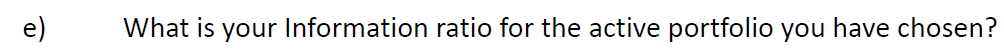

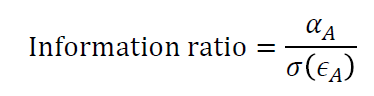

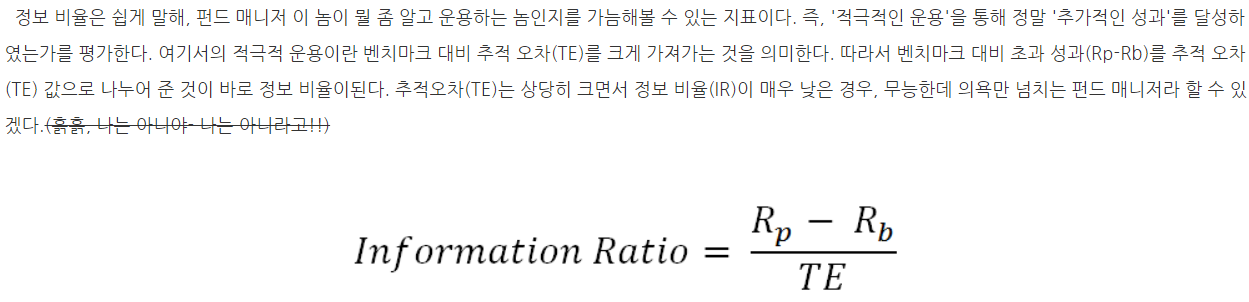

In [390]:
information_ratio = sum( np.array(stat.T['alpha']) * optimized_weight[:3] )
print('inforamtion ratio : ' + str(information_ratio)[:7])

inforamtion ratio : 0.01878


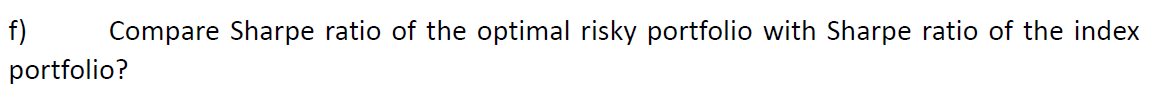

In [392]:
index_SR = excess_market.mean() / excess_market.std()
print('optimal_risky_portfolio : ' + str(optimized_SR)[:7])
print('index_SR : ' + str(index_SR)[:7])

optimal_risky_portfolio : 0.50233
index_SR : -0.0744
